# Modelo de AI para Identificación de Carros - DL
Jorge de Jesús Castro Vázquez | A01707735

18/Mayo/2025

# CODIGO

# Cargar Dataset de Google Drive

In [ ]:
# Instalar las dependências necessárias para o projeto
%pip install tensorflow  matplotlib pandas scikit-learn numpy 

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ---------------------------------------- 0.0/376.0 MB ? eta -:--:--
   ---------------------------------------- 0.8/376.0 MB 4.8 MB/s eta 0:01:18
   ---------------------------------------- 2.1/376.0 MB 5.6 MB/s eta 0:01:07
   ---------------------------------------- 3.7/376.0 MB 6.2 MB/s eta 0:01:00
    --------------------------------------- 5.5/376.0 MB 6.9 MB/s eta 0:00:55
    --------------------------------------- 6.8/376.0 MB 7.0 MB/s eta 0:00:53
    --------------------------------------- 7.9/376.0 MB 6.6 MB/s eta 0:00:56
    --------------------------------------- 8.7/376.0 MB 6.5 MB/s eta 0:00:57
   - -------------------------------------- 10.0/376.0 MB 6.1 MB/s eta 0:01:01
   - -------------------------------------- 11.3/376.0 MB 6.1 MB/s eta 0:01:00
   - -------------------------------------- 12.8/376.0 MB 6.3 MB/s eta 0:00:58
   - -------------------------------------- 14.7/376.0 MB 6.5 MB/s eta 0:00:56
   

ERROR: Could not install packages due to an OSError: [WinError 2] El sistema no puede encontrar el archivo especificado: 'c:\\Python312\\Scripts\\wheel.exe' -> 'c:\\Python312\\Scripts\\wheel.exe.deleteme'


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, optimizers
from tensorflow.keras.utils import img_to_array, load_img
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix, classification_report

### Declaración de Path, tamaño de imageen y verificación

In [7]:
train_dir = 'Cars Dataset/train'
test_dir = 'Cars Dataset/test'
val_dir = 'Cars Dataset/val'

IMG_SIZE=128

## Separación de Dataset a VAL 

In [8]:
# Este snippet fue hecho con Gemini AI para separar una cantidad de imagenes del TRAIN
# y usarlos como VAL del Modelo.
import shutil
import random


# Crear la carpeta en el path origen sí no existe
if not os.path.exists(val_dir):
  os.makedirs(val_dir)

# Leer la las classes que hay en el train
train_subdirs = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]

# Indicar la cantidad de imagenes que se quieren para Val
num_images_per_class = 100

# Crear los directorios y
for subdir in train_subdirs:
  train_subdir_path = os.path.join(train_dir, subdir)
  val_subdir_path = os.path.join(val_dir, subdir)

  if not os.path.exists(val_subdir_path):
    os.makedirs(val_subdir_path)

  images = [f for f in os.listdir(train_subdir_path) if os.path.isfile(os.path.join(train_subdir_path, f))]

  # Seleccion random de 30 imagenes de cada subcarpeta
  selected_images = random.sample(images, min(num_images_per_class, len(images)))

  # Mover imagenes de train a val
  for image_name in selected_images:
    src_path = os.path.join(train_subdir_path, image_name)
    dest_path = os.path.join(val_subdir_path, image_name)
    shutil.move(src_path, dest_path)
    print(f"Moved {image_name} from {train_subdir_path} to {val_subdir_path}")

print("Validation dataset created successfully.")


Moved 1358.jpg from Cars Dataset/train\Audi to Cars Dataset/val\Audi
Moved 676.jpg from Cars Dataset/train\Audi to Cars Dataset/val\Audi
Moved 1045.jpg from Cars Dataset/train\Audi to Cars Dataset/val\Audi
Moved 804.jpg from Cars Dataset/train\Audi to Cars Dataset/val\Audi
Moved 192.jpg from Cars Dataset/train\Audi to Cars Dataset/val\Audi
Moved 412.jpg from Cars Dataset/train\Audi to Cars Dataset/val\Audi
Moved 116.jpg from Cars Dataset/train\Audi to Cars Dataset/val\Audi
Moved 335.jpg from Cars Dataset/train\Audi to Cars Dataset/val\Audi
Moved 1344.jpg from Cars Dataset/train\Audi to Cars Dataset/val\Audi
Moved 1092.jpg from Cars Dataset/train\Audi to Cars Dataset/val\Audi
Moved 885.jpg from Cars Dataset/train\Audi to Cars Dataset/val\Audi
Moved 949.jpg from Cars Dataset/train\Audi to Cars Dataset/val\Audi
Moved 173.jpg from Cars Dataset/train\Audi to Cars Dataset/val\Audi
Moved 1034.jpg from Cars Dataset/train\Audi to Cars Dataset/val\Audi
Moved 125.jpg from Cars Dataset/train\Audi 

# Contar la cantidad de imágenes en cada carpeta

In [8]:
from prettytable import PrettyTable

def count_files_in_folders(directory):
  """
  Counts the number of files in each subfolder of a given directory.

  Args:
    directory (str): The path to the directory to analyze.

  Returns:
    list: A list of dictionaries, where each dictionary contains the
          'Folder Name' and 'File Count' for a subfolder.
  """
  folder_data = []
  for root, dirs, files in os.walk(directory):
    file_count = len(files)
    folder_data.append({'Folder Name': os.path.relpath(root, directory), 'File Count': file_count})
  return folder_data

def print_file_count_table(directory):
  """
  Prints a table showing the file count for each subfolder.

  Args:
    directory (str): The path to the directory to analyze.
  """
  folder_data = count_files_in_folders(directory)

  table = PrettyTable()
  table.field_names = ["Folder Name", "File Count"]

  for data in folder_data:
    table.add_row([data['Folder Name'], data['File Count']])

  print(table)

# Example usage with your train and test directories:
print("File counts in train directory:")
print_file_count_table(train_dir)

print("\nFile counts in test directory:")
print_file_count_table(test_dir)

print("\nFile counts in val directory:")
print_file_count_table(val_dir)


File counts in train directory:
+------------------+------------+
|   Folder Name    | File Count |
+------------------+------------+
|        .         |     0      |
|       Audi       |    714     |
|  Hyundai Creta   |    171     |
| Mahindra Scorpio |    216     |
|   Rolls Royce    |    211     |
|      Swift       |    324     |
|   Tata Safari    |    341     |
|  Toyota Innova   |    675     |
+------------------+------------+

File counts in test directory:
+------------------+------------+
|   Folder Name    | File Count |
+------------------+------------+
|        .         |     0      |
|       Audi       |    199     |
|  Hyundai Creta   |     67     |
| Mahindra Scorpio |     75     |
|   Rolls Royce    |     74     |
|      Swift       |    102     |
|   Tata Safari    |    106     |
|  Toyota Innova   |    190     |
+------------------+------------+

File counts in val directory:
+------------------+------------+
|   Folder Name    | File Count |
+------------------+-

# Configuración y Preparación de Dataset

## Configuración de Data Augmentation 
Se hace un reescalamiento, se aplica zoom, shear, horizontal flip y rotación

In [9]:
# Configuración del obejto ImageDataGenerator para aplicar augmentation
train_datagen = ImageDataGenerator(
							rescale = 1./255, # Reescalamiento de la imagen
							rotation_range = 10,
							width_shift_range = 0.1,
							height_shift_range = 0.1,
						  shear_range = 0.25,
							zoom_range = 0.3,
							horizontal_flip = True)

### Aplicar Data Augmentation

In [10]:
# 
train_generator = train_datagen.flow_from_directory(
							train_dir,
							target_size = (IMG_SIZE, IMG_SIZE),
							batch_size = 32,
							class_mode ='categorical',
							)
images, labels = train_generator[0]

print(f"Shape of images: {images.shape}")
print(f"Shape of labels: {labels.shape}")

Found 2652 images belonging to 7 classes.
Shape of images: (32, 128, 128, 3)
Shape of labels: (32, 7)


<Figure size 640x480 with 0 Axes>

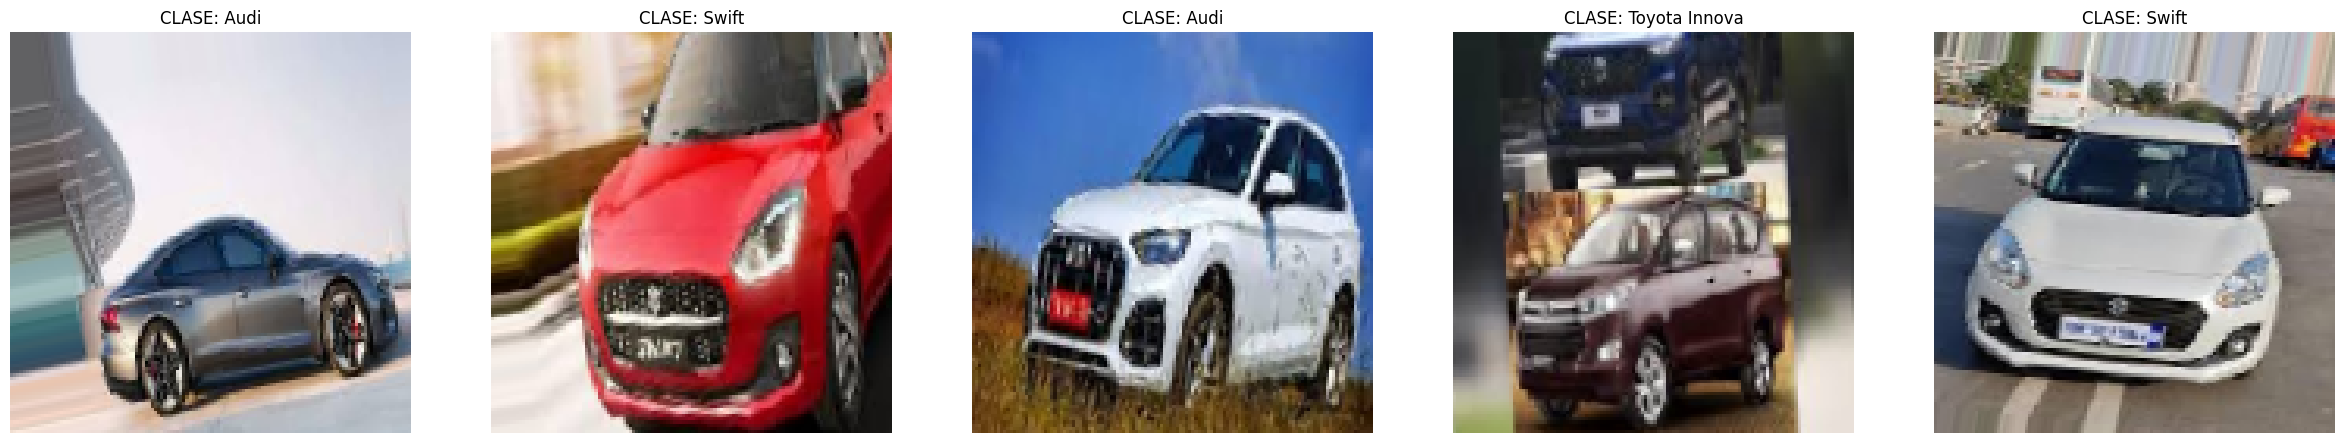

In [11]:
plt.figure()

f, axarr = plt.subplots(1, 5, figsize=(30, 8))
images, labels = train_generator[0]

# Mapa de Labels
label_map = {v: k for k, v in train_generator.class_indices.items()}

for i in range(5):
	axarr[i].imshow(images[i])
	class_index = tf.argmax(labels[i]).numpy()
	class_name = label_map[class_index]
	axarr[i].set_title(f"CLASE: {class_name}")
	axarr[i].axis('off')

In [12]:
# Preparación de los generadores de validación y test para métricas y evaluación
rescale_images_config = ImageDataGenerator(rescale=1./255)

val_rescale_generator = rescale_images_config.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=16,
    class_mode='categorical',
    shuffle=False  # No mezclar las imágenes para mantener el orden
)

test_rescale_generator = rescale_images_config.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=16,
    class_mode='categorical',
    shuffle=False  # No mezclar las imágenes para mantener el orden
)

Found 700 images belonging to 7 classes.
Found 813 images belonging to 7 classes.


## Pimer Arquitectura de CNN [Kaggle]

In [14]:
img_shape = (IMG_SIZE, IMG_SIZE, 3)
model_kaggle = models.Sequential()

## Compilación del modelo

In [15]:
# Construcción de la Red Neuronal Kaggle
img_shape = (IMG_SIZE, IMG_SIZE, 3)
model_kaggle = models.Sequential()

model_kaggle.add(Conv2D(32, (3, 3), input_shape=img_shape, activation='relu'))
model_kaggle.add(MaxPooling2D(pool_size=(2, 2)))

model_kaggle.add(Conv2D(32, (3, 3), activation='relu'))
model_kaggle.add(MaxPooling2D(pool_size=(2, 2)))

model_kaggle.add(Flatten())

model_kaggle.add(Dense(units=96, activation='relu'))
model_kaggle.add(Dropout(0.40))
model_kaggle.add(Dense(units=32, activation='relu'))
model_kaggle.add(Dense(units=7, activation='softmax')) # softmax for more than 2

model_kaggle.summary()

model_kaggle.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])



c:\Users\CVJJ1\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 96)             │     2,764,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,778,375 (10.60 MB)

 Trainable params: 2,778,375 (10.60 MB)

 Non-trainable params: 0 (0.00 B)

## Clase auxiliar para guardar Test Performance

In [13]:
class TestPerformance(tf.keras.callbacks.Callback):
    def __init__(self, test_data):
        super().__init__()
        self.test_data = test_data
        self.test_losses = []
        self.test_accs   = []

    def on_epoch_end(self, epoch, logs=None):
        loss, acc = self.model.evaluate(
            self.test_data,
            verbose=0
        )
        self.test_losses.append(loss)
        self.test_accs.append(acc)
        logs = logs or {}
        logs["test_loss"] = loss
        logs["test_accuracy"] = acc

test_callback_base = TestPerformance(test_data=test_rescale_generator)
test_callback_optimized = TestPerformance(test_data=test_rescale_generator)

## Entrenamiento del Modelo Kaggle

In [27]:
history_base = model_kaggle.fit(
    train_generator,
    epochs=50,
    validation_data=val_rescale_generator,
    callbacks=[test_callback_base],
)

Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 17s 199ms/step - accuracy: 0.6212 - loss: 1.0613 - val_accuracy: 0.5186 - val_loss: 1.3579 - test_loss: 1.0534 - test_accuracy: 0.6248
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 17s 203ms/step - accuracy: 0.6230 - loss: 1.0639 - val_accuracy: 0.4886 - val_loss: 1.5173 - test_loss: 1.1995 - test_accuracy: 0.5966
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 17s 204ms/step - accuracy: 0.6496 - loss: 1.0198 - val_accuracy: 0.5471 - val_loss: 1.3145 - test_loss: 1.0477 - test_accuracy: 0.6408
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 16s 191ms/step - accuracy: 0.6526 - loss: 0.9824 - val_accuracy: 0.5471 - val_loss: 1.2014 - test_loss: 1.0143 - test_accuracy: 0.6408
Epoch 5/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 16s 192ms/step - accuracy: 0.6530 - loss: 1.0057 - val_accuracy: 0.4657 - val_loss: 1.5501 - test_loss: 1.2166 - test_accuracy: 0.5683
Epoch 6/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 16s 192ms/step - accuracy: 0.6367 - loss: 1.0102 - val_accuracy: 0.5271 - val_loss: 1.3493 - test

In [28]:
model_kaggle.save('model_kaggle.keras')

## Métricas del Modelo Kaggle

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.7244 - loss: 0.7819
Test accuracy: 0.6851168274879456
                  precision    recall  f1-score   support

            Audi       0.61      0.91      0.73       199
   Hyundai Creta       0.70      0.24      0.36        67
Mahindra Scorpio       0.73      0.43      0.54        75
     Rolls Royce       0.57      0.27      0.37        74
           Swift       0.72      0.67      0.69       102
     Tata Safari       0.77      0.77      0.77       106
   Toyota Innova       0.73      0.83      0.78       190

        accuracy                           0.69       813
       macro avg       0.69      0.59      0.61       813
    weighted avg       0.69      0.69      0.66       813



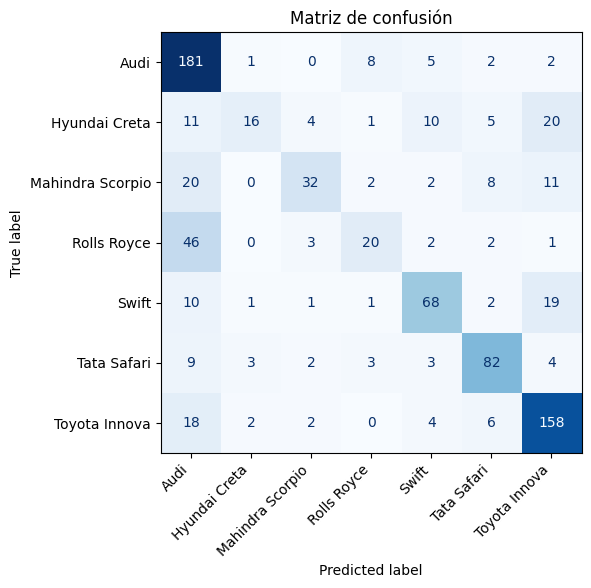

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

test_loss, test_acc = model_kaggle.evaluate(test_rescale_generator)
print(f"Test accuracy: {test_acc}")

labels = list(test_rescale_generator.class_indices.keys())

y_true = test_rescale_generator.classes
y_pred = np.argmax(model_kaggle.predict(test_rescale_generator, verbose=0), axis=1)

# Generación de la matriz de confusión y reporte de clasificación
cm = confusion_matrix(y_true, y_pred)
print(classification_report(y_true, y_pred, target_names=labels))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

plt.figure(figsize=(6, 6))
disp.plot(include_values=True, cmap=plt.cm.Blues, ax=plt.gca(), colorbar=False)
plt.title("Matriz de confusión")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


## Gráficas y Visualización de Resultados

In [32]:
test_loss, test_acc = model_kaggle.evaluate(test_rescale_generator)
print(f"Test accuracy: {test_acc} | Test loss: {test_loss}")

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7244 - loss: 0.7819
Test accuracy: 0.6851168274879456 | Test loss: 0.8840852975845337


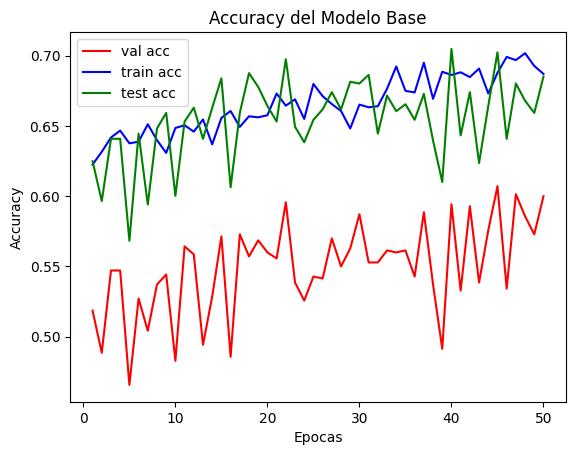

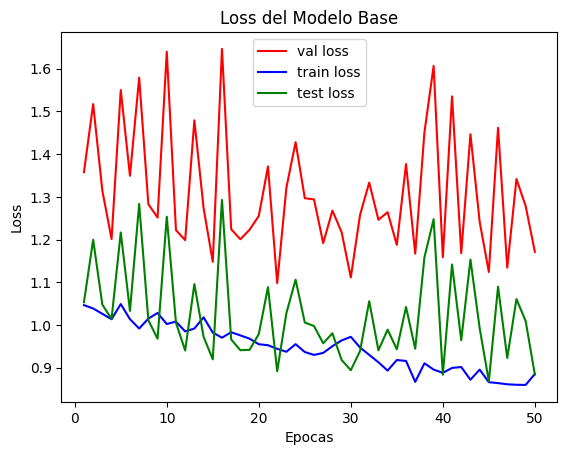

In [35]:
# Declarar los valores a gráficar: Train y Val. Test se evaluó anterioremente
train_accuracy = history_base.history['accuracy']
train_loss = history_base.history['loss']

val_accuracy = history_base.history['val_accuracy']
val_loss = history_base.history['val_loss']

num_epochs = range(1, len(train_accuracy) + 1)

# Graficar Accuracy del Modelo
plt.figure()

# Definir las Series que vamos a graficar
plt.plot(num_epochs, val_accuracy, 'r', label='val acc')
plt.plot(num_epochs, train_accuracy, 'b', label='train acc')
plt.plot(num_epochs, test_callback_base.test_accs, 'g', label='test acc')

# Configuración de Labels y Titulo de la gráfica
plt.title('Accuracy del Modelo Base')
plt.xlabel('Epocas')
plt.ylabel('Accuracy')
plt.legend()

# Graficar Loss del Modelo
plt.figure()

# Definir las Series que vamos a graficar
plt.plot(num_epochs, val_loss, 'r', label='val loss')
plt.plot(num_epochs, train_loss, 'b', label='train loss')
plt.plot(num_epochs, test_callback_base.test_losses, 'g', label='test loss')

# Configuración de Labels y título de gráfico
plt.title('Loss del Modelo Base')
plt.xlabel('Epocas')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Segundo Modelo Ajustado [Optimized]

## Segunda Arquitectura de CNN [Optimized]

In [14]:
img_shape = (IMG_SIZE, IMG_SIZE, 3)
model_optimized = models.Sequential()

model_optimized.add(Conv2D(16,(3, 3),activation="relu", kernel_constraint=max_norm(3), input_shape=img_shape))
model_optimized.add(MaxPooling2D((2, 2)))

model_optimized.add(Conv2D(32, (3, 3),activation="relu", kernel_constraint=max_norm(3), input_shape=img_shape))
model_optimized.add(MaxPooling2D((2, 2)))

model_optimized.add(Conv2D(64, (3, 3),activation="relu", kernel_constraint=max_norm(3)))
model_optimized.add(MaxPooling2D((2, 2)))

model_optimized.add(Dropout(0.2))

model_optimized.add(Conv2D(128, (3, 3), activation="relu", kernel_constraint=max_norm(3)))
model_optimized.add(MaxPooling2D((2, 2)))

model_optimized.add(Flatten())

model_optimized.add(Dropout(0.5))
model_optimized.add(Dense(512, activation='relu'))
model_optimized.add(Dense(7, activation='softmax'))

model_optimized.summary()

c:\Users\CVJJ1\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,460,839 (9.39 MB)

 Trainable params: 2,460,839 (9.39 MB)

 Non-trainable params: 0 (0.00 B)

## Compilación del modelo ajustado

In [15]:
model_optimized.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Entrenamiendo del Modelo Optimizado

In [16]:
history_optimized = model_optimized.fit(
    train_generator,
    epochs= 50, 
    validation_data=val_rescale_generator,
    callbacks=[test_callback_optimized])

c:\Users\CVJJ1\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 35s 386ms/step - accuracy: 0.2621 - loss: 1.8257 - val_accuracy: 0.2386 - val_loss: 1.9762 - test_loss: 1.7901 - test_accuracy: 0.3567
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 33s 396ms/step - accuracy: 0.3709 - loss: 1.7198 - val_accuracy: 0.2100 - val_loss: 2.1172 - test_loss: 1.8587 - test_accuracy: 0.3087
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 32s 380ms/step - accuracy: 0.4027 - loss: 1.6344 - val_accuracy: 0.2986 - val_loss: 1.7448 - test_loss: 1.4943 - test_accuracy: 0.4416
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 28s 339ms/step - accuracy: 0.4430 - loss: 1.5415 - val_accuracy: 0.2929 - val_loss: 1.8267 - test_loss: 1.5884 - test_accuracy: 0.4034
Epoch 5/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 28s 338ms/step - accuracy: 0.4875 - loss: 1.4180 - val_accuracy: 0.3429 - val_loss: 1.7382 - test_loss: 1.4303 - test_accuracy: 0.4859
Epoch 6/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 36s 434ms/step - accuracy: 0.5219 - loss: 1.3806 - val_accuracy: 0.4029 - val_loss: 1.6041 - test

In [17]:
model_optimized.save("model_optimized.keras")

## Métricas del modelo Optimizado

51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.8642 - loss: 0.4447
Test accuracy: 0.8388683795928955
                  precision    recall  f1-score   support

            Audi       0.78      0.91      0.84       199
   Hyundai Creta       0.68      0.76      0.72        67
Mahindra Scorpio       0.81      0.89      0.85        75
     Rolls Royce       0.77      0.58      0.66        74
           Swift       0.90      0.80      0.85       102
     Tata Safari       0.92      0.79      0.85       106
   Toyota Innova       0.94      0.91      0.92       190

        accuracy                           0.84       813
       macro avg       0.83      0.81      0.81       813
    weighted avg       0.84      0.84      0.84       813



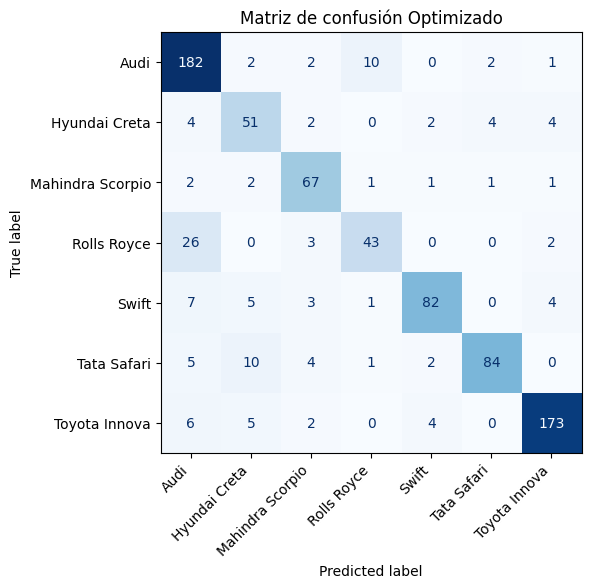

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

test_loss, test_acc = model_optimized.evaluate(test_rescale_generator)
print(f"Test accuracy: {test_acc}")

labels = list(test_rescale_generator.class_indices.keys())

y_true = test_rescale_generator.classes
y_pred = np.argmax(model_optimized.predict(test_rescale_generator, verbose=0), axis=1)

# Generación de la matriz de confusión y reporte de clasificación
cm = confusion_matrix(y_true, y_pred)
print(classification_report(y_true, y_pred, target_names=labels))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

plt.figure(figsize=(6, 6))
disp.plot(include_values=True, cmap=plt.cm.Blues, ax=plt.gca(), colorbar=False)
plt.title("Matriz de confusión Optimizado")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


## Gráficas y Visualización de Resultados

In [19]:
test_loss, test_acc = model_optimized.evaluate(test_rescale_generator)
print(f"Test accuracy: {test_acc} | Test loss: {test_loss}")

51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.8642 - loss: 0.4447
Test accuracy: 0.8388683795928955 | Test loss: 0.5366071462631226


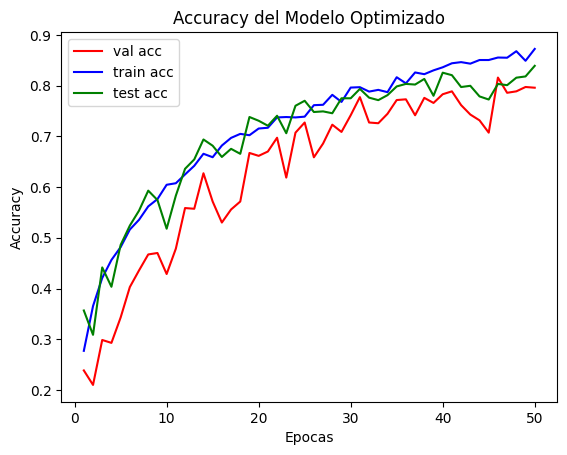

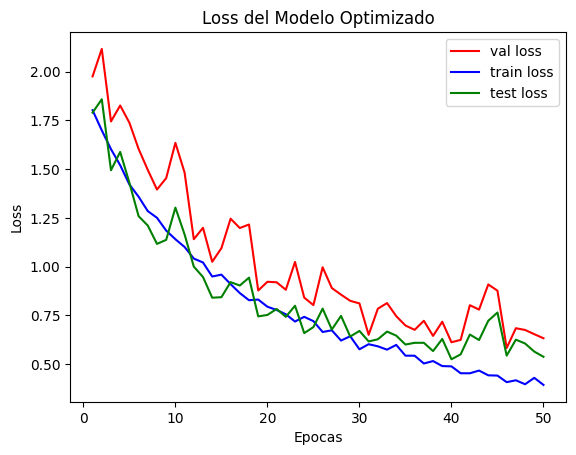

In [20]:
# Declarar los valores a gráficar: Train y Val. Test se evaluó anterioremente
train_accuracy = history_optimized.history['accuracy']
train_loss = history_optimized.history['loss']

val_accuracy = history_optimized.history['val_accuracy']
val_loss = history_optimized.history['val_loss']

num_epochs = range(1, len(train_accuracy) + 1)

# Graficar Accuracy del Modelo
plt.figure()

# Definir las Series que vamos a graficar
plt.plot(num_epochs, val_accuracy, 'r', label='val acc')
plt.plot(num_epochs, train_accuracy, 'b', label='train acc')
plt.plot(num_epochs, test_callback_optimized.test_accs, 'g', label='test acc')

# Configuración de Labels y Titulo de la gráfica
plt.title('Accuracy del Modelo Optimizado')
plt.xlabel('Epocas')
plt.ylabel('Accuracy')
plt.legend()

# Graficar Loss del Modelo
plt.figure()

# Definir las Series que vamos a graficar
plt.plot(num_epochs, val_loss, 'r', label='val loss')
plt.plot(num_epochs, train_loss, 'b', label='train loss')
plt.plot(num_epochs, test_callback_optimized.test_losses, 'g', label='test loss')

# Configuración de Labels y título de gráfico
plt.title('Loss del Modelo Optimizado')
plt.xlabel('Epocas')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Zona de Predicciónes

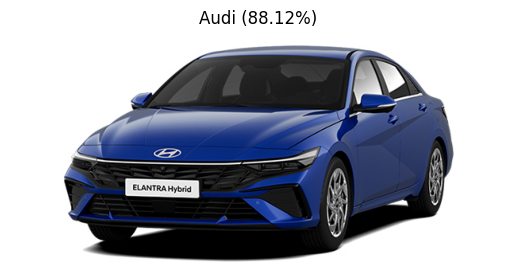

In [24]:
import json, numpy as np, tensorflow as tf
from pathlib import Path
import matplotlib.pyplot as plt

# --- 1. Carga del modelo y diccionario de clases ----------------------------
model_path   = Path("model_optimized.keras")                
#model_path   = Path("model_kaggle.keras")                

model = tf.keras.models.load_model(model_path)

# --- 2. Función auxiliar para pre-procesar y predecir ------------------------
def predict_image(img_path):

    img = tf.keras.utils.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    x   = tf.keras.utils.img_to_array(img) / 255.0  
    x   = np.expand_dims(x, axis=0)                       

    preds = model.predict(x, verbose=0)
    class_id = int(np.argmax(preds))
    conf     = float(np.max(preds))

    return label_map[class_id], conf, preds[0]

# --- 3. Elegir una imagen local ---------------------------------------------
img_path = Path("Pruebas/hyundai.jpg")     

assert img_path.exists(), f"No se encontró {img_path}"

predicted_class, confidence, prob_vector = predict_image(img_path)

# --- 4. Mostrar resultado ----------------------------------------------------
plt.imshow(tf.keras.utils.load_img(img_path))
plt.axis("off")
plt.title(f"{predicted_class} ({confidence:.2%})")
plt.show()
